# Exploratory Data Analysis (EDA)

Start by importing the packages needed for EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import scipy
import plotly.graph_objects as go

sns.set_theme()

Read in the cleaned data from data wrangling.

In [2]:
df = pd.read_csv("../data/clean_data.csv", index_col=0)

# Visualizations

These visualizations will be used to look through the data and see different relations between the target variables (Happiness, Future, and Hardwork) and other important variables that may be important to the model. 

I will create three different sets of visualizations:
* Distributions of each variable
* Distributions of categorical variables separated by Happiness, Future, and Hardwork
* Boxplots of running variables separated by Happiness, Future, and Hardwork

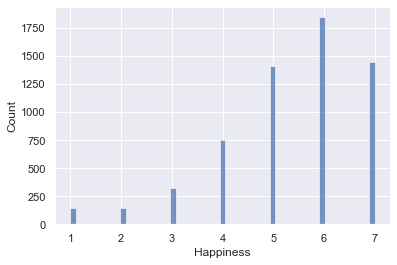

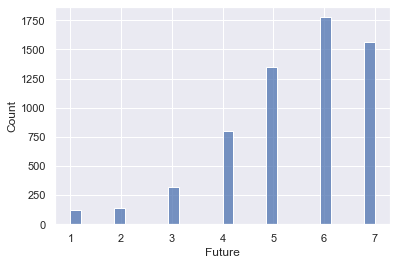

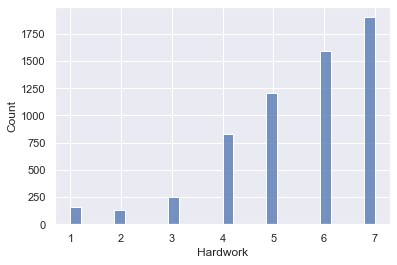

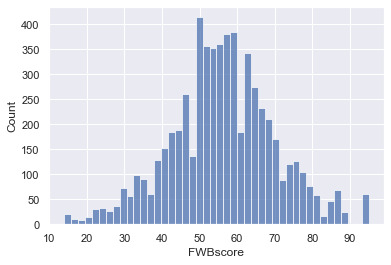

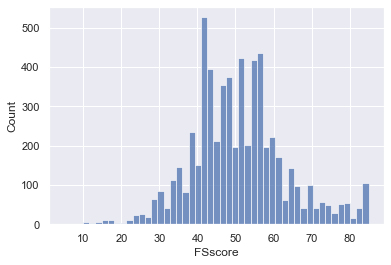

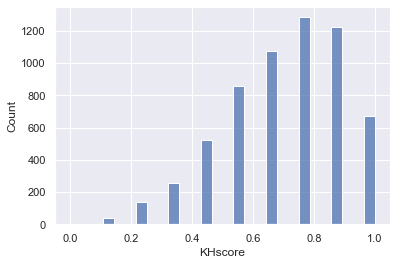

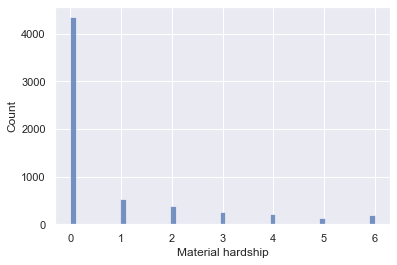

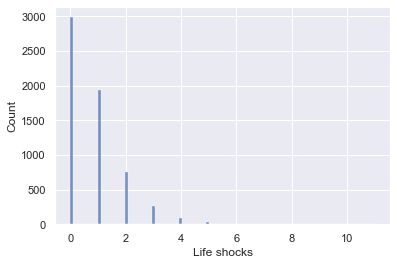

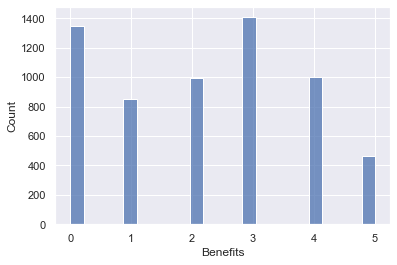

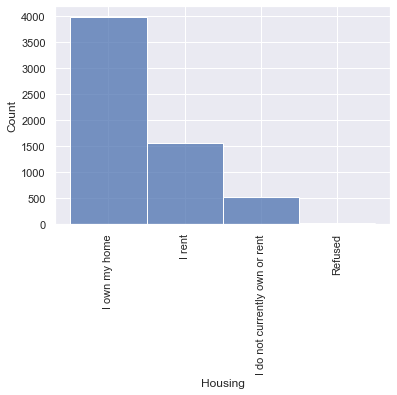

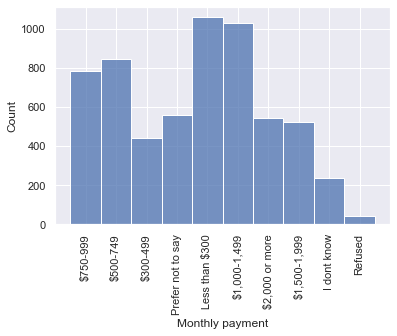

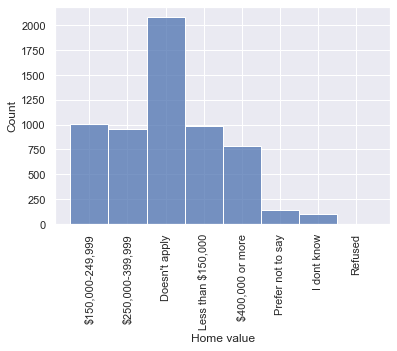

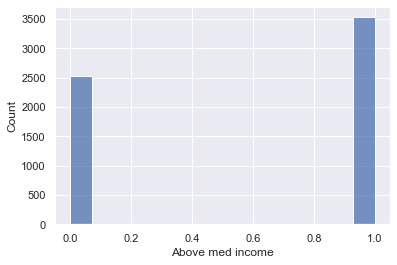

In [3]:
important_vars = ["Happiness", "Future", "Hardwork", # Target variables
                  "FWBscore", "FSscore", "KHscore", "Material hardship", "Life shocks", "Benefits", # Running variables
                  "Housing", "Monthly payment", "Home value", "Above med income"] # Categorical variables

for i in important_vars:
    sns.histplot(x=i, data=df)
    if df[i].dtype == object:
        plt.xticks(rotation=90)
    plt.show()

There are several things that can be inferred from these distributions. The target variables are left skewed and about 50% of the data answered either 6 or 7. The financial wellbeing test scores were relatively normally distributed except for the KHscore. 

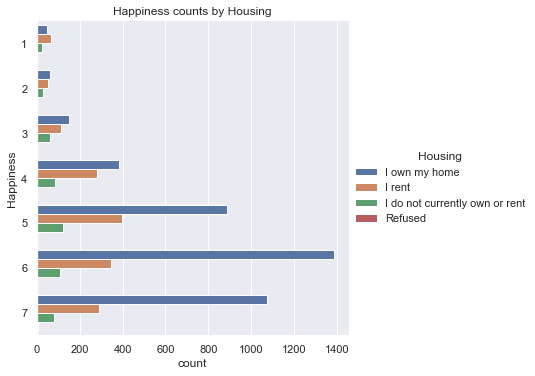

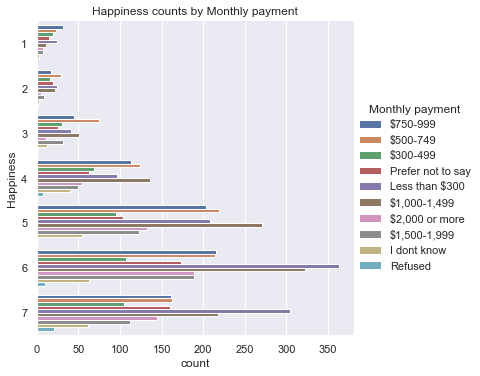

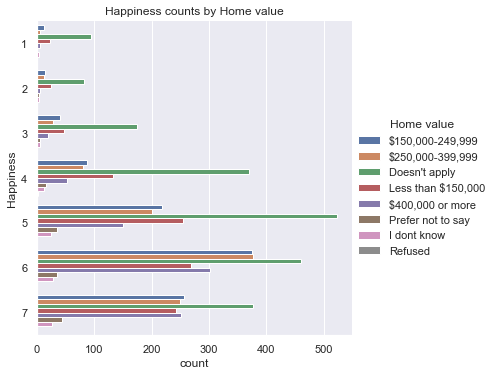

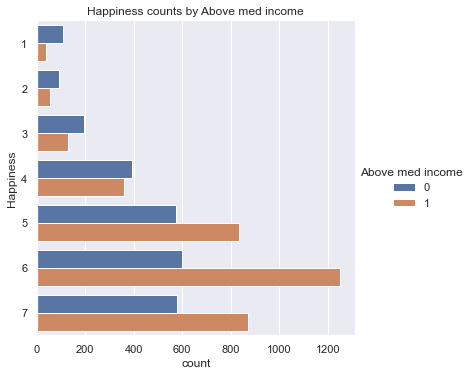

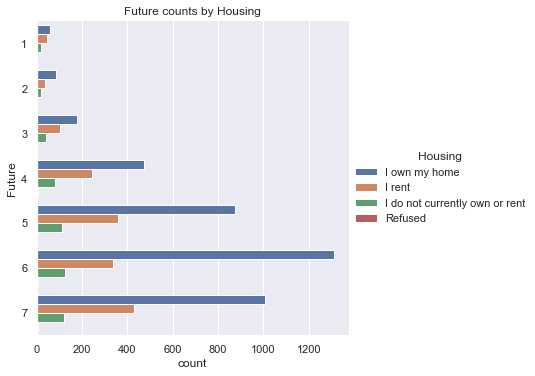

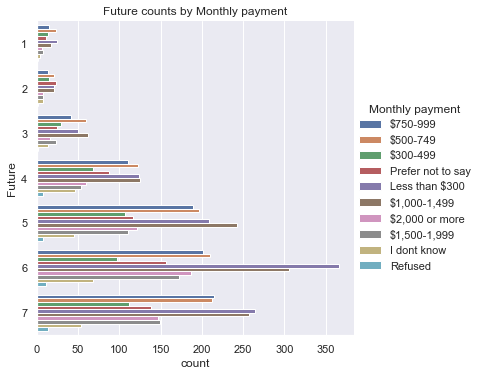

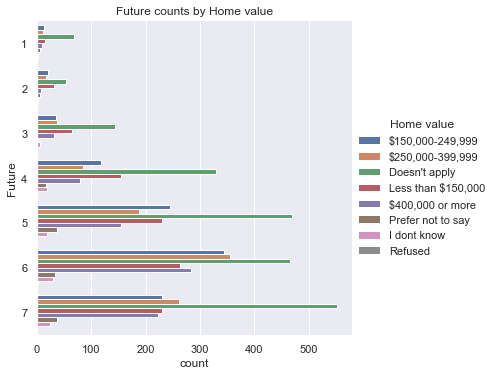

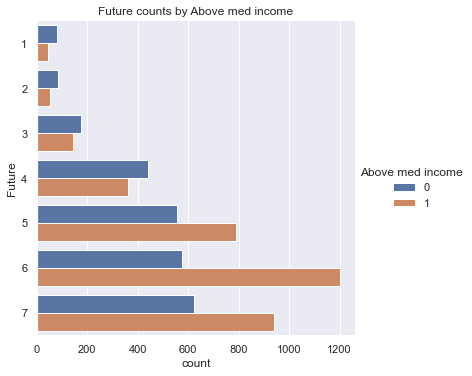

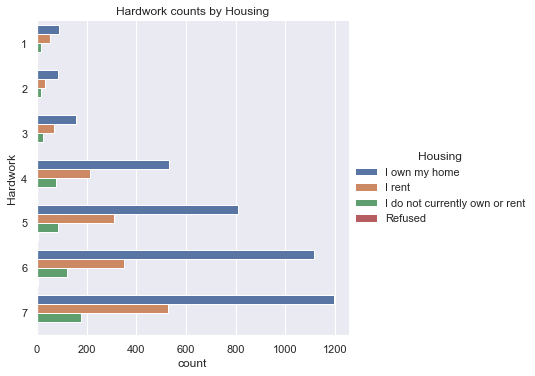

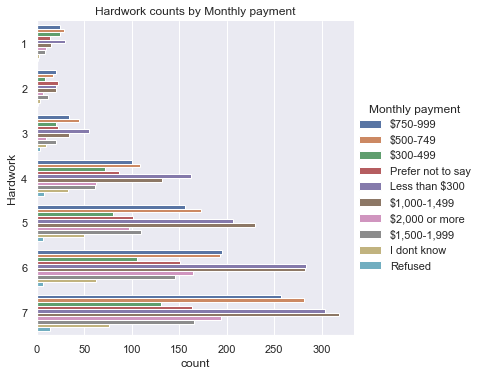

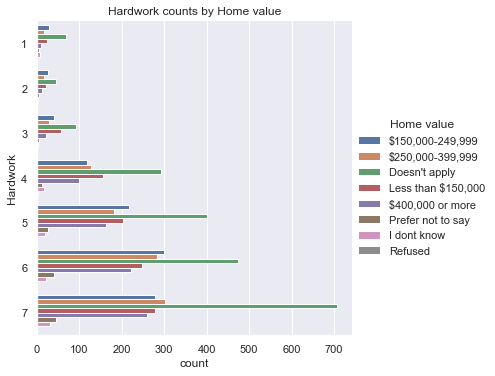

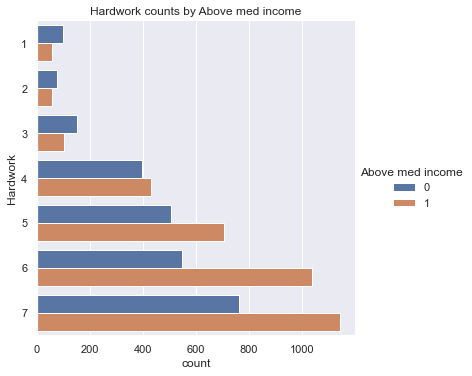

In [4]:
hue_columns = ["Happiness", "Future", "Hardwork"]
x_columns = ["Housing", "Monthly payment", "Home value", "Above med income"]

for hue in hue_columns:
    for x in x_columns:
        sns.catplot(y=hue, hue=x, data=df, kind="count", orient="h")
        plt.title(f"{hue} counts by {x}")
        plt.show()

Even though most of the people surveyed own a home, it appears that there are double or even triple the number of homeowners than those that rent for those that had a happiness of 5, 6, or 7. This may be a variable to perform a statistical test on.

It also appears that those that make above the median income also are happier than those that make less than the medain income. This is also a variable to perform a statistical test on. 

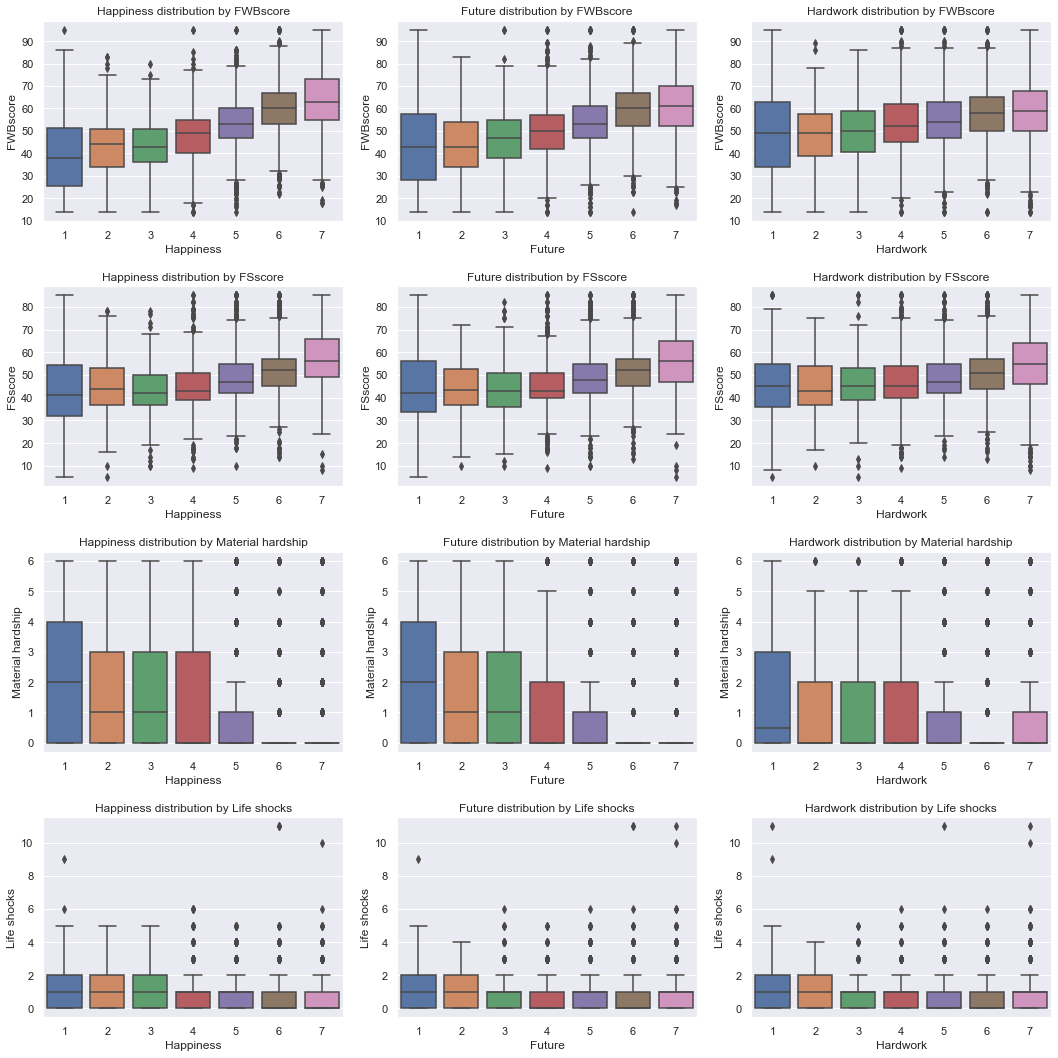

In [5]:
cols = ["Happiness", "Future", "Hardwork"]
rows = ["FWBscore", "FSscore", "Material hardship", "Life shocks"]

fig, ax = plt.subplots(nrows=len(rows), ncols=len(cols), figsize=(15, 15))

for row in range(len(rows)): 
    for col in range(len(cols)):
        sns.boxplot(x=cols[col], y=rows[row], data=df, ax=ax[row, col])
        ax[row, col].set_title(f"{cols[col]} distribution by {rows[row]}")
        
fig.tight_layout(pad=1.5)
plt.show()

The financial well-being test (FWBscore) appears to be significantly higher for those that scored a 6 or 7* on happiness. This is something that could be tested by creating a binary value for those that scored 6 or 7* and comparing the means of these two groups. 

The other financial tests do not seem to be all that different for future or hardwork scores. It appears that material hardship is something that impacts all the target variables and seems to be significantly higher for those that scored low in all the target variables. These could also be tested by creating a binary variable for those that scored 6 or 7*.

\*From the first set of visualizations it was evident that the target variables was left skewed. Approximately 50% of respondents answered 6 or 7 for each target variable and this is another reason that this would be a good binary split. 

In [6]:
df["Happiness67"] = df.Happiness.isin((6, 7))
df["Future67"] = df.Future.isin((6, 7))
df["Hardwork67"] = df.Hardwork.isin((6, 7))

df[["Happiness67", "Future67", "Hardwork67"]].describe()

,Happiness67,Future67,Hardwork67
count,6069,6069,6069
unique,2,2,2
top,True,True,True
freq,3295,3338,3491


# Inferential Statistics

I think that it would be interesting to see if it is likely that there is a difference in mean of the Happiness of the people that are above the median income and those below the median income. Based on the graphs above it appears that there could be. 

I also think that it would be interesting to test to see if those that scored had a higher Financial Well-being score (FWBScore) are more likely to be have a higher Happiness rating. Based on the graphs it appears that this could be a possibility. 

In [7]:
# Separate those above median income and below.
above = df[df["Above med income"]==1]
below = df[df["Above med income"]==0]

# Get the variables needed for the t-test
n_above = len(above)
n_below = len(below)
avg_above = above.Happiness.mean()
avg_below = below.Happiness.mean()
std_above = above.Happiness.std()
std_below = below.Happiness.std()

# Test 
scipy.stats.ttest_ind_from_stats(avg_above, std_above, n_above, 
                                 avg_below, std_below, n_below)

Ttest_indResult(statistic=12.944916068490793, pvalue=7.926569454483891e-38)

This test results in a very low p-value which indicates that it is likely that the average Happiness score is higher for those above the median income. 

In [8]:
h67 = df[df.Happiness67==True]
h15 = df[df.Happiness67!=True]

n_67 = len(h67)
avg_67 = h67.FWBscore.mean()
std_67 = h67.FWBscore.std()
n_15 = len(h15)
avg_15 = h15.FWBscore.mean()
std_15 = h15.FWBscore.std()

scipy.stats.ttest_ind_from_stats(avg_67, std_67, n_67, 
                                 avg_15, std_15, n_15)

Ttest_indResult(statistic=37.905239911298786, pvalue=2.2581352575245513e-282)

This test also results in a very low p-value which indicates on average, those that have a Happiness score of 6 or 7 have a higher financial well-being score. 

## Create Sankey Diagram

Using the floWeaver library create Sankey diagrams to visualize the flow of the answers.

In [51]:
sankey = df[["Home value", "Housing", "Monthly payment", "Happiness"]].groupby(["Housing", "Home value", "Monthly payment"]).count()

sankey = sankey.reset_index()
sankey.columns = ["source", "type", "target", "value"]

In [15]:
import floweaver as fw
from ipysankeywidget import SankeyWidget

# Set the size the diagram will be in the notebook
size = dict(width=570, height=300)

In [55]:
nodes = {"Housing": fw.ProcessGroup(list(df["Housing"].unique())),
         "Monthly payment": fw.ProcessGroup(list(df["Monthly payment"].unique()))}

nodes["Housing"].partition = fw.Partition.Simple("process", list(df["Housing"].unique()))
nodes["Monthly payment"].partition = fw.Partition.Simple("process", list(df["Monthly payment"].unique()))

# nodes["waypoint"] = fw.Waypoint()
# waypoint = fw.Partition.Simple("type", list(df["Home value"].unique()))
# nodes["waypoint"] = waypoint

ordering = [["Housing"],
#             ["waypoint"],
            ["Monthly payment"],]

bundles = [fw.Bundle("Housing", "Monthly payment"),]#, waypoints=["waypoint"]

In [56]:
sdd = fw.SankeyDefinition(nodes, bundles, ordering)

fw.weave(sdd, sankey).to_widget(**size)

SankeyWidget(groups=[{'id': 'Housing', 'type': 'process', 'title': '', 'nodes': ['Housing^I own my home', 'Hou…